In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random
import tqdm

In [2]:
class SmallCardNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)   # adjust 8×8 to your resized size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class RandomBackgroundComposite:
    def __init__(self, bgs_path: Path = Path('../data/card_classifier/backgrounds')):
        self.bg_paths = sorted(bgs_path.glob("*.png"))
        if not self.bg_paths:
            raise ValueError(f"No background images found in {bgs_path}")

    def __call__(self, fg_rgba: Image.Image) -> Image.Image:
        fg = fg_rgba.convert("RGBA")

        bg_path = random.choice(self.bg_paths)
        with Image.open(bg_path) as bg_rgb:
            bg = bg_rgb.convert("RGBA").resize(fg.size)

        out = Image.alpha_composite(bg, fg)
        return out.convert("RGB")

In [4]:
image_path = Path('../data/deckshop_cards')

In [5]:
class FlatImageDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        self.root = Path(root_dir)
        card_paths = self.root.glob('*.png')
        self.paths = [path for path in card_paths]

        # label name = filename without extension
        self.class_names = [p.stem for p in self.paths]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGBA")
        if self.transform:
            img = self.transform(img)

        label_name = path.stem
        label = self.class_to_idx[label_name]
        return img, label

In [6]:
class RandomPad:
    def __init__(self, max_pad=8, fill=0):
        self.max_pad = max_pad
        self.fill = fill

    def __call__(self, img):
        p = random.randint(0, self.max_pad)
        return transforms.Pad(p, fill=self.fill)(img)

In [7]:
# Example transforms
train_tf = transforms.Compose([
    RandomPad(50, fill=(0,0,0,0)),
    transforms.Resize((64, 64)),
    transforms.RandomRotation(5, fill=(0, 0, 0, 0)),
    RandomBackgroundComposite(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.RandomGrayscale(p=0.5),
    transforms.ToTensor(),
])

ds = FlatImageDataset("../data/deckshop_cards", transform=train_tf)
loader = DataLoader(ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

print(len(ds), ds.class_names[:5])

121 ['Exe', 'ArcherQuee', 'Clone', 'SkeletonDragons', 'Vines']


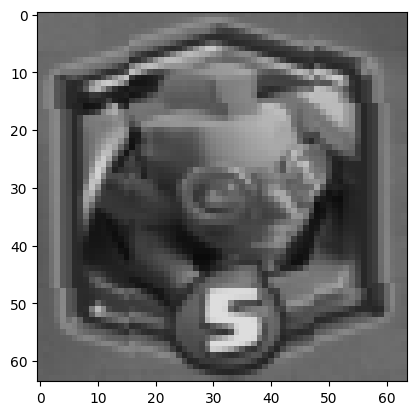

In [79]:
img, label = ds.__getitem__(55)
img_foreground = img.permute(1, 2, 0)
plt.imshow(img_foreground)
plt.show()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print("Device:", device)

# num_classes from your ImageFolder
num_classes = len(ds.class_names)

model = SmallCardNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()               # for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), 
                              lr=1e-3, 
                              weight_decay=1e-4)


Device: cpu


In [25]:
num_epochs = 150
epoch_bar = tqdm.tqdm(range(num_epochs), desc="loss: - acc:")
for epoch in epoch_bar:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)          # [batch, num_classes]
        loss = criterion(outputs, labels)

        # backward + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    epoch_bar.set_description(f"- loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f}")

- loss: 0.0021 - acc: 1.0000: 100%|███████████| 150/150 [01:34<00:00,  1.58it/s]


In [17]:
test_tfm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [18]:
def predict_card(model, img_path, classes, tfm):
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        logits = model(x.to(next(model.parameters()).device))
    idx = logits.argmax(1).item()
    return classes[idx]

In [19]:
model_name = 'model_v2.pth'
save_path = Path().resolve().parents[0] / 'king_tensor' / 'models' / model_name
torch.save(model.state_dict(), save_path)

Balloon


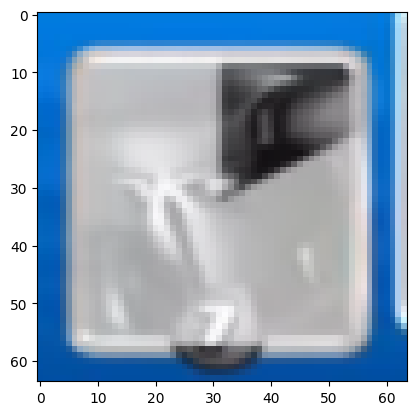

In [63]:
test_img_path = Path('../data/card_classifier/pbs/pekka/0018.png').resolve()
test_img = Image.open(test_img_path).convert("RGB")
transformed_img = test_tfm(test_img).permute(1, 2, 0)
plt.imshow(transformed_img)
prediction = predict_card(model, test_img_path, ds.class_names, test_tfm)
print(prediction)